# How To Backtest Machine Learning Models for Time Series Forecasting


[blog link](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/ )


## Abstract

Demonstrates different ways to split train and test sets for Time Series data using backcasting. 

## Introduction


Learning goals from blog post.

* The limitations of traditional methods of model evaluation from machine learning and why evaluating models on out of sample data is required.
* How to create train-test splits and multiple train-test splits of time series data for model evaluation in Python.
* How walk-forward validation provides the most realistic evaluation of machine learning models on time series data.


Train/test splits must be done cautiously because traditional k-fold cross validation does not respect the temporal nature of the data observations.

In time series forecasting, this evaluation of models on historical data is called **backtesting**.


Three methods for splitting up data.

* Train-Test split that respect temporal order of observations.
* Multiple Train-Test splits that respect temporal order of observations.
* Walk-Forward Validation where a model may be updated each time step new data is received.

## Data

## Methods

## Results

## Discussion

## Conclusion



<br>
<br>

# Imports

In [1]:
import os

import data_science_tools as tools
from matplotlib.pylab import plt
import seaborn as sns
import numpy as np
import pandas as pd

import src

In [2]:
%matplotlib inline
tools.config.initialize()

<br>
<br>

# Parameters

<br>
<br>

# Raw Data

## df_month_sunspots


In [3]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'

df_month_sunspots = pd.read_csv(url, header=0)
df_month_sunspots.columns = [c.lower() for c in df_month_sunspots.columns]
df_month_sunspots.set_index('month', inplace=True)
df_month_sunspots.index = df_month_sunspots.index.map(pd.Timestamp)

In [4]:
df_month_sunspots.head()

,sunspots
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


<br>
<br>

# Processed Data

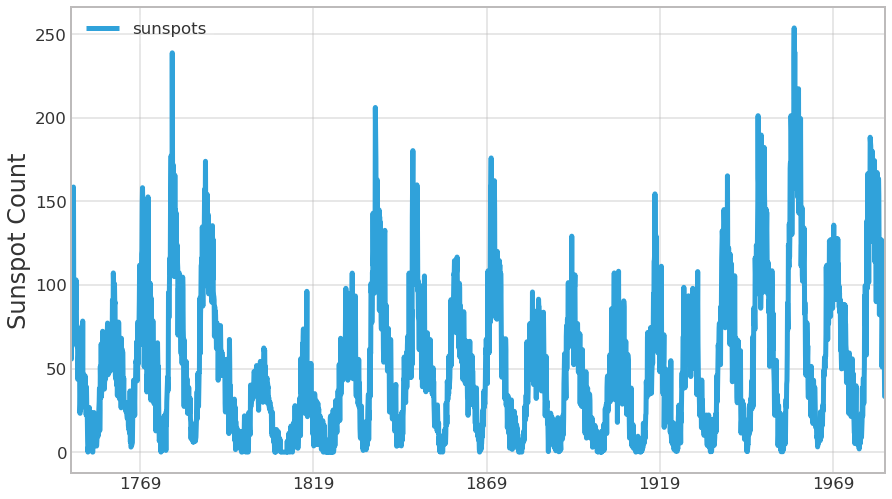

In [5]:
df_month_sunspots.plot()
plt.ylabel('Sunspot Count')
plt.xlabel('')
plt.show()

In [6]:
df_month_sunspots.head()

,sunspots
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [7]:
df_processed = pd.DataFrame(index=df_month_sunspots.index)
df_processed['shift_1'] = df_month_sunspots.shift(1)['sunspots']
df_processed['y'] = df_month_sunspots['sunspots']

<br>
<br>

# Model

In [31]:
def build_model():
    import xgboost
    model = xgboost.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000,
    )
    return model

In [32]:
model = build_model()

<br>
<br>

# Training

In [59]:
def train_model(model, training_sets):
    history = []
    
    for train, test in training_sets:
        size = len(train) + len(test)
        print(f"""
        Observations: {size}
        Training Observations: {len(train)} ({len(train)/size: .0%})
        Test Observations: {len(test)} ({len(test)/size: .0%})
        """)
        
        train_X = np.asarray(train)[:, :-1]
        train_y = np.asarray(train)[:, -1:]
        
        model.fit(train_X, train_y)
        
        test_X = np.asarray(test)[:, :-1]
        test_y = np.asarray(test)[:, -1:]
        
        pred_y = model.predict(test_X)
        history.append({
            'train_X': train_X,
            'train_y': train_y,
            'pred_y': pred_y,
            'test_X': test_X,
            'test_y': test_y,
        })
    return history
    
    

<br>
<br>
<br>
<br>


## Single Train-Test Split

In [60]:
BATCH_SIZE = len(df_processed)
TRAIN_SIZE = int(BATCH_SIZE * 0.66)


def single_train_test_split(df_processed, train_size=TRAIN_SIZE):
    yield df_processed.iloc[:train_size], df_processed.iloc[train_size:]


In [61]:
train, test = split_train_test(df_processed)

In [62]:
print(f"""
Observations: {BATCH_SIZE}
Training Observations: {len(train)} ({len(train) / BATCH_SIZE: .0%})
Test Observations: {len(test)} ({len(test)/BATCH_SIZE: .0%})
""")


Observations: 2820
Training Observations: 1861 ( 66%)
Test Observations: 959 ( 34%)



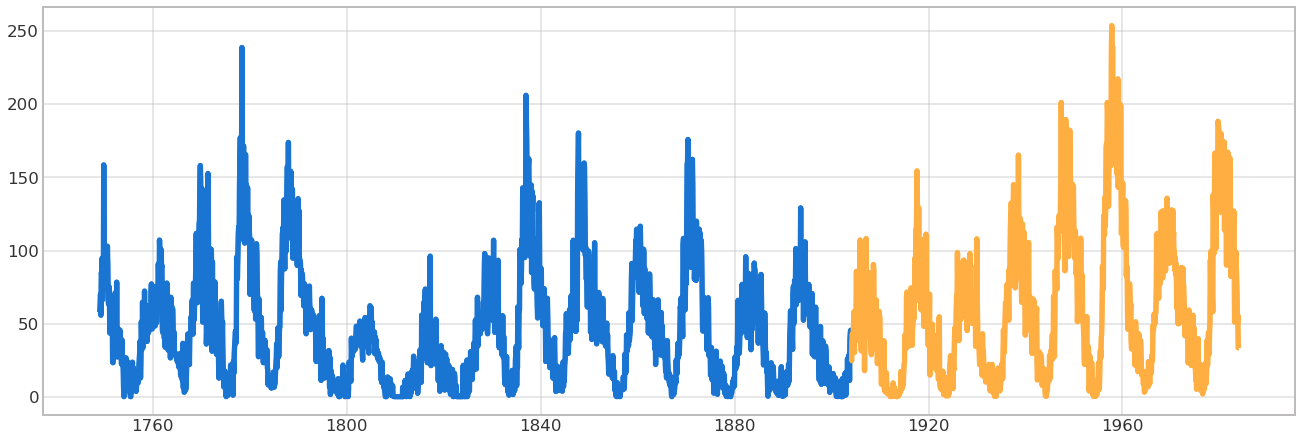

In [63]:
colors = sns.color_palette('Set3', 10)

plt.figure(figsize=(20, 7))

plt.plot(train, label='train', color=tools.crayons.navy_blue)
plt.plot(test, label='test', color=tools.crayons.yellow_orange)
plt.show()

In [82]:
history = train_model(
    model,
    single_train_test_split(df_processed),
)


        Observations: 2820
        Training Observations: 1861 ( 66%)
        Test Observations: 959 ( 34%)
        


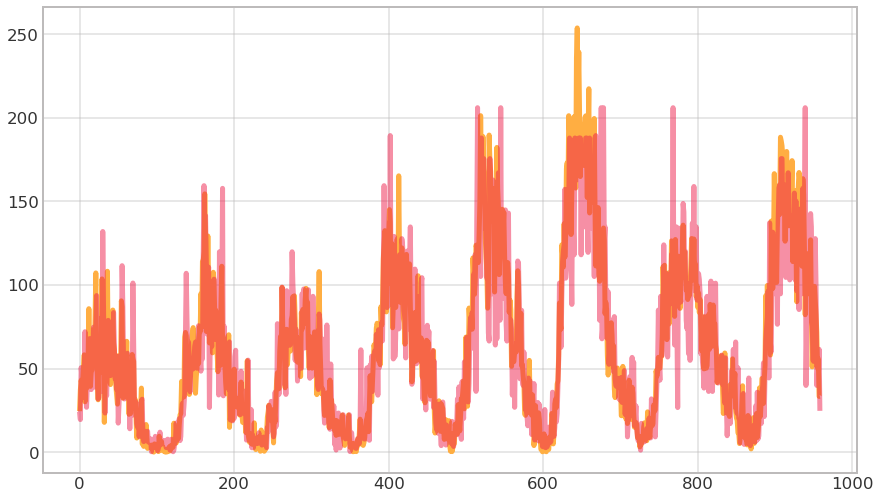

In [83]:
h = history[0]
plt.plot(h['test_y'].ravel(), color=tools.crayons.yellow_orange)
plt.plot(h['pred_y'].ravel(), color=tools.crayons.red, alpha=0.5)

<br>
<br>
<br>
<br>


## Multiple Train-Test Splits

We can repeat the process of splitting the time series into train and test sets multiple times.

**Manual Method**

In [16]:
i = 2
n_samples = 2000
n_splits = 3

0 500 500 1000
0 1000 1000 1500
0 1500 1500 2000


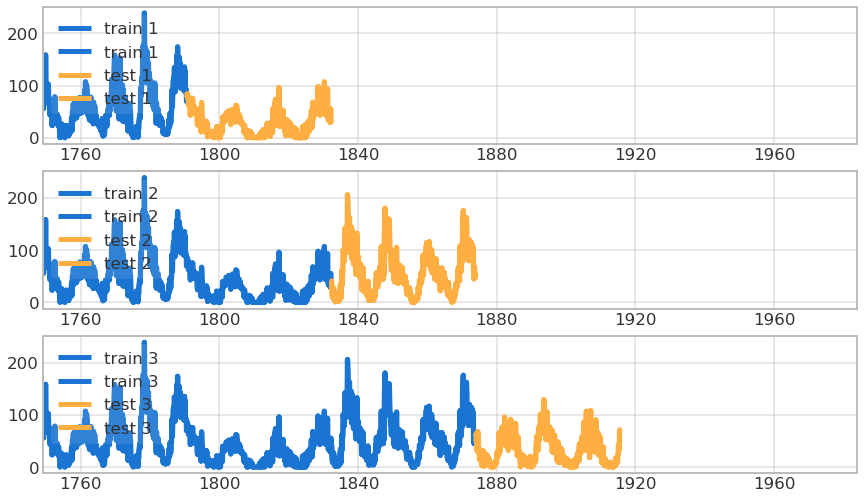

In [71]:
fig, axes = plt.subplots(n_splits, 1)
axes = iter(axes.ravel())

for i in range(1, n_splits + 1):
    plt.sca(next(axes))
    training_size = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
    test_size = n_samples / (n_splits + 1)
    
    i_start = 0
    i_end = int(training_size)
    j_start = i_end
    j_end = int(i_end + test_size)
    
    train = df_processed.iloc[i_start:i_end]
    test = df_processed.iloc[j_start:j_end]
    
    plt.plot(train, label=f'train {i}', color=tools.crayons.navy_blue)
    plt.plot(test, label=f'test {i}', color=tools.crayons.yellow_orange)
    print(i_start, i_end, j_start, j_end)
    plt.xlim(df_processed.index.min(), df_processed.index.max())

    plt.legend()

plt.show()

**Using sklearn.model_selection.TimeSeriesSplit**

In [72]:
from sklearn.model_selection import TimeSeriesSplit

In [73]:
def multiple_train_test_splits(df_processed, n_splits=n_splits):
    splits = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in splits.split(df_processed): 
        print(f'Train={len(train_index)} Test={len(test_index)}')
        print(min(train_index), max(train_index))
        print(min(test_index), max(test_index))
        
        train = df_processed.iloc[train_index]
        test = df_processed.iloc[test_index]
        
        yield train, test


Train=705 Test=705
0 704
705 1409
Train=1410 Test=705
0 1409
1410 2114
Train=2115 Test=705
0 2114
2115 2819


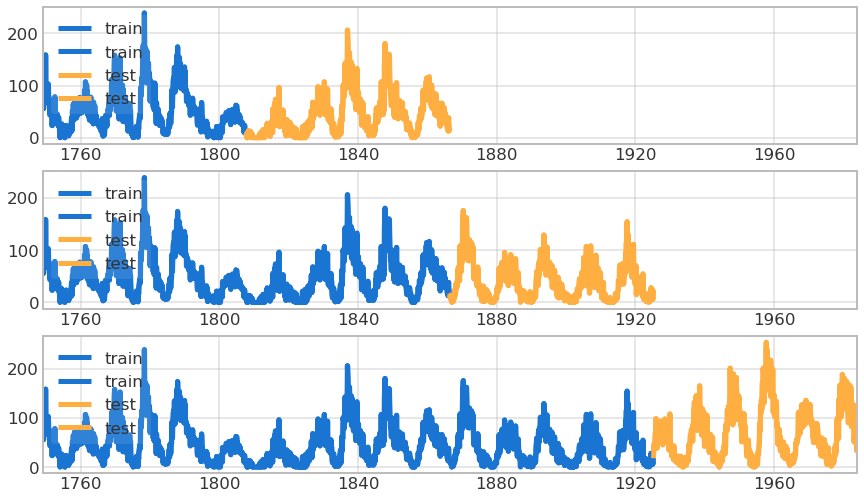

In [75]:
colors = iter(sns.color_palette('Set3', 10))

fig, axes = plt.subplots(n_splits, 1)
axes = iter(axes.ravel())

xmin, xmax = None, None
for train, test in multiple_train_test_splits(df_processed):
    plt.sca(next(axes))

    plt.plot(train, label=f'train', color=tools.crayons.navy_blue)
    plt.plot(test, label=f'test', color=tools.crayons.yellow_orange)

    plt.xlim(df_processed.index.min(), df_processed.index.max())
    plt.legend()


<br>
<br>

## Walk Forward Validation: Expanding Window

Parameters

* Minimum Number of Observations.
* Sliding or Expanding Window.

Process:

1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
1. The model makes a prediction for the next time step.
1. The prediction is stored or evaluated against the known value.
1. The window is expanded to include the known value and the process is repeated (go to step 1.)



In [76]:
MIN_TRAIN_SIZE = 1000
TEST_SIZE = 300

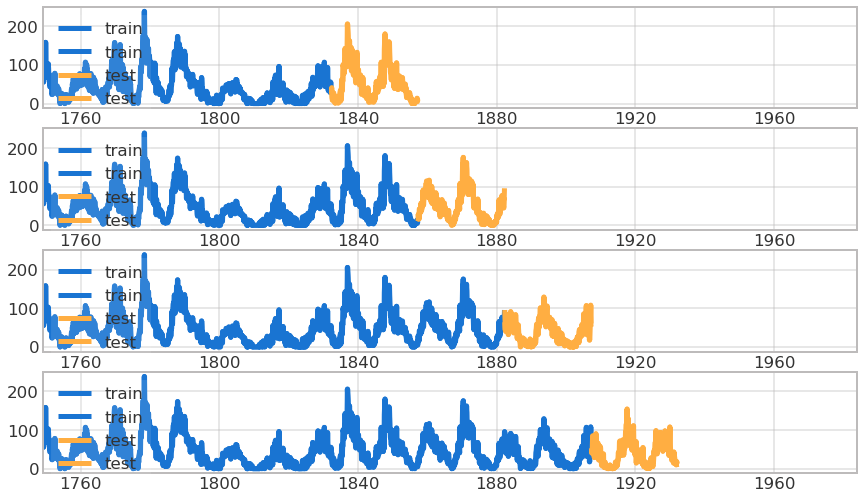

In [77]:
iteration_count = 4

fig, axes = plt.subplots(iteration_count, 1)
axes = iter(axes.ravel())

i0_train = 0
i1_train = MIN_TRAIN_SIZE
i0_test = i1_train
i1_test = i1_train + TEST_SIZE

for i in range(iteration_count):

    train = df_processed.iloc[i0_train:i1_train]
    test = df_processed.iloc[i0_test:i1_test]
    
    # expand window
    i0_train = 0
    i1_train = i1_test
    i0_test = i1_test
    i1_test = i0_test + TEST_SIZE    

    plt.sca(next(axes))

    plt.plot(train, label=f'train', color=tools.crayons.navy_blue)
    plt.plot(test, label=f'test', color=tools.crayons.yellow_orange)
    plt.xlim(df_processed.index.min(), df_processed.index.max())
    plt.legend()
    



<br>
<br>

## Walk Forward Validation: Sliding Window



In [78]:
MIN_TRAIN_SIZE = 500
TEST_SIZE = 200

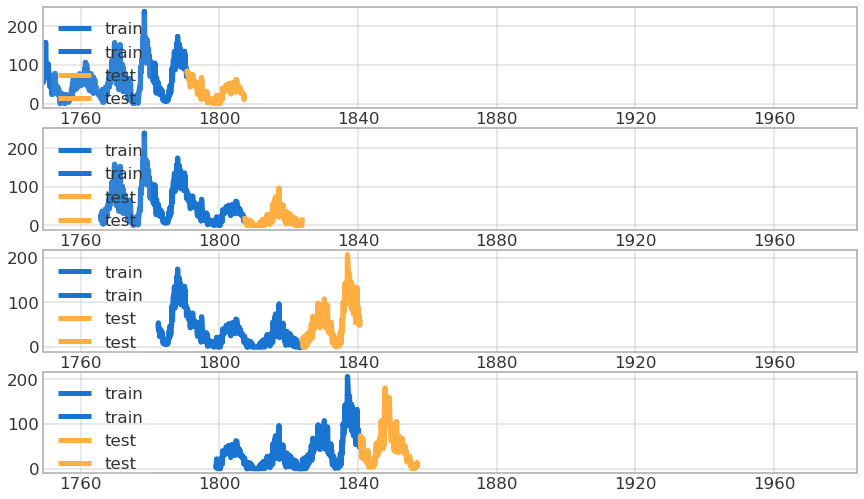

In [79]:
iteration_count = 4

fig, axes = plt.subplots(iteration_count, 1)
axes = iter(axes.ravel())

i0_train = 0
i1_train = MIN_TRAIN_SIZE
i0_test = i1_train
i1_test = i1_train + TEST_SIZE

for i in range(iteration_count):
    train = df_processed.iloc[i0_train:i1_train]
    test = df_processed.iloc[i0_test:i1_test]
    
    # slide window
    i0_train = i1_test - MIN_TRAIN_SIZE
    i1_train = i1_test
    i0_test = i1_test
    i1_test = i0_test + TEST_SIZE    

    plt.sca(next(axes))

    plt.plot(train, label=f'train', color=tools.crayons.navy_blue)
    plt.plot(test, label=f'test', color=tools.crayons.yellow_orange)
    plt.xlim(df_processed.index.min(), df_processed.index.max())
    plt.legend()
